In [1]:
import pandas as pd
import os
import shutil as sh
import yaml
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import numpy as np

In [2]:
import torch

# 查看 PyTorch 版本
print("PyTorch 版本:", torch.__version__)

# 检查 CUDA 是否可用
print("CUDA 是否可用:", torch.cuda.is_available())

# 查看 CUDA 版本
print("CUDA 版本:", torch.version.cuda)

PyTorch 版本: 2.5.1+cu118
CUDA 是否可用: True
CUDA 版本: 11.8


In [3]:
# Paths
train_img_dir = r'D:\code_study\ML_CODE\dataSets\1ObjectDetection\Car_Object_Detection\data\training_images'
test_img_dir = r'D:\code_study\ML_CODE\dataSets\1ObjectDetection\Car_Object_Detection\data\testing_images'
output_dir = '.\working'
train_csv_path = r'D:\code_study\ML_CODE\dataSets\1ObjectDetection\Car_Object_Detection\data\train_solution_bounding_boxes (1).csv'
test_csv_path = r'D:\code_study\ML_CODE\dataSets\1ObjectDetection\Car_Object_Detection\data\sample_submission.csv'

In [4]:
# Create directories for processed data
data_dir = os.path.join(output_dir, 'mydata')
images_dir = os.path.join(data_dir, 'images')
labels_dir = os.path.join(data_dir, 'labels')

os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

In [5]:
# Load the train CSV file
train_df = pd.read_csv(train_csv_path)

In [6]:
# Function to convert bbox to YOLO format
def convert_bbox_yolo(size, bbox):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (bbox[0] + bbox[1]) / 2.0 - 1
    y = (bbox[2] + bbox[3]) / 2.0 - 1
    w = bbox[1] - bbox[0]
    h = bbox[3] - bbox[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

In [7]:
# Save images and labels
for idx, data in train_df.groupby('image'):
    image_path = os.path.join(train_img_dir, idx)
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Unable to read image {image_path}")
            continue
        
        height, width, _ = img.shape
        data = data[['xmin', 'xmax', 'ymin', 'ymax']].values
        yolo_bboxes = [convert_bbox_yolo((width, height), bbox) for bbox in data]
        yolo_bboxes = np.array(yolo_bboxes).astype(str)
        
        with open(os.path.join(labels_dir, f'{idx.replace(".jpg", "")}.txt'), 'w+') as f:
            for bbox in yolo_bboxes:
                text = '0 ' + ' '.join(bbox)
                f.write(text + '\n')
        
        sh.copy(image_path, os.path.join(images_dir, idx))
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

In [8]:
# Create YAML file for YOLO training
with open(os.path.join(output_dir, 'yolov5/dataset.yaml'), 'w') as f:
    f.write(f'path: {data_dir}\n')
    f.write('train: images\n')
    f.write('val: images\n\n')
    f.write('names:\n')
    f.write('  0: car\n')

In [9]:
# Train the YOLO model
#!python train.py --img 640 --batch 16 --epochs 30 --data {output_dir}/yolov5/dataset.yaml --weights ./yolov5s.pt

!python train.py --data {output_dir}/yolov5/dataset.yaml --epochs 30 --weights '' --cfg yolov5s.yaml  --batch-size 4

github: skipping check (offline), for updates see https://github.com/ultralytics/yolov5


train: weights='', cfg=yolov5s.yaml, data=.\working/yolov5/dataset.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=30, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
YOLOv5  v7.0-397-gde62f93c Python-3.9.21 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.

In [30]:
# Evaluate and visualize results
import torch
from pathlib import Path
# Load the best model
#model_path = os.path.join("D:\\code_study\\Github\\yolov5", '\\runs\\train\\exp10\\weights\\best.pt')
model_path = Path("D:\\code_study\\Github\\yolov5\\runs\\train\\exp10\\weights\\best.pt")
print(f"Model path: {model_path}")
if not os.path.exists(model_path):
    print("Model path does not exist, check if training was successful.")

# Load the model using the correct path
model = torch.hub.load('', 'custom', path=model_path, source='local')

YOLOv5  v7.0-397-gde62f93c Python-3.9.21 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)

Fusing layers... 


Model path: D:\code_study\Github\yolov5\runs\train\exp10\weights\best.pt


YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Test images: ['D:\\code_study\\ML_CODE\\dataSets\\1ObjectDetection\\Car_Object_Detection\\data\\testing_images\\vid_5_25100.jpg', 'D:\\code_study\\ML_CODE\\dataSets\\1ObjectDetection\\Car_Object_Detection\\data\\testing_images\\vid_5_25120.jpg', 'D:\\code_study\\ML_CODE\\dataSets\\1ObjectDetection\\Car_Object_Detection\\data\\testing_images\\vid_5_25140.jpg']
Processing image: D:\code_study\ML_CODE\dataSets\1ObjectDetection\Car_Object_Detection\data\testing_images\vid_5_25100.jpg
Results: image 1/1: 380x676 (no detections)
Speed: 2.0ms pre-process, 3.0ms inference, 117.9ms NMS per image at shape (1, 3, 384, 640)
Plotting results...
Processing image: D:\code_study\ML_CODE\dataSets\1ObjectDetection\Car_Object_Detection\data\testing_images\vid_5_25120.jpg
Results: image 1/1: 380x676 (no detections)
Speed: 0.5ms pre-process, 3.0ms inference, 4.0ms NMS per image at shape (1, 3, 384, 640)
Plotting results...
Processing image: D:\code_study\ML_CODE\dataSets\1ObjectDetection\Car_Object_Detecti

d:\code_study\Github\yolov5\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
d:\code_study\Github\yolov5\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
d:\code_study\Github\yolov5\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


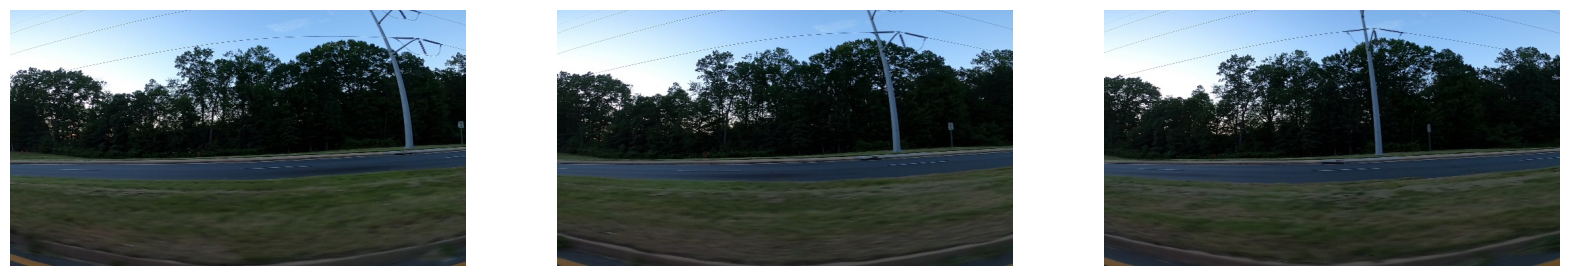

In [37]:
# Function to plot images with detected boxes
%matplotlib inline
def plot_images_with_boxes(img, results, ax):
    print("Plotting results...")
    for *box, conf, cls in results.xyxy[0].cpu().numpy():
        print(f"Box: {box}, Confidence: {conf}, Class: {cls}")
        x1, y1, x2, y2 = map(int, box)
        img = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box
        label = f'{int(cls)} {conf:.2f}'
        img = cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')

# Get three test images
test_images = [os.path.join(test_img_dir, img) for img in os.listdir(test_img_dir)[:3]]
print(f"Test images: {test_images}")

# Plot images with predictions
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

for i, test_image_path in enumerate(test_images):
    print(f"Processing image: {test_image_path}")
    img = cv2.imread(test_image_path)
    if img is None:
        print(f"Warning: Unable to read image {test_image_path}")
        continue
    results = model(img)
    print(f"Results: {results}")
    plot_images_with_boxes(img, results, axs[i])

plt.show()